# 慢性肾炎数据集处理及拟合模型

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 读取csv文件，返回DataFrame

In [2]:
def load_chronic_kidney_dataset(filename):
    data=pd.read_csv(filename,delimiter=',')
    if 'mice'in filename or 'KNN'in filename:
        data.rename(columns={ data.columns[0]: "delete" }, inplace=True)
        data.drop('delete',axis=1,inplace=True)
    target_names=['ckd','notckd']
    if data.shape[1]==24:
        y_num=pd.read_csv('/home/min/bigdata/data/ex1/data/chronicNumric.csv',delimiter=',')['class']
        data=data.join(y_num)
    y_num=data['class']
    target_labels=[]
    for c in y_num:
        target_labels.append(target_names[int(c)])
    plot_data=data.copy()
    y_class=pd.DataFrame(target_labels,columns=['class'])
    plot_data['class']=y_class
    return plot_data,data

### 原始数据连续值得离散化

In [3]:
#discrete_data 要划分的数据集
#source_data 原始的缺失数据集
def discrete_data(dis_data,source_data,k=6):
    numerics=['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
    rate_list=[]
    for i in range(1,k):
        rate_list.append(i/float(k))
    rate=np.array(rate_list)
    for it in numerics:
        attribute_with_nan=source_data[it]
        attribute=sorted(attribute_with_nan.dropna().values)
        qs=len(attribute)*rate
        qs1=np.ceil(qs)
        qs2=np.floor(qs)
        qs1=qs1.astype(np.int32)
        qs2=qs2.astype(np.int32)
        qss=[]
        for i in range(len(rate)):
            qss.append((attribute[qs1[i]]+attribute[qs2[i]])/2)
        def change2category(x):
            if not np.isnan(x):
                c=0
                while(c<len(qss) and x>qss[c]):
                    c+=1
                return c
            return x
        attribute_category=map(change2category,dis_data[it].values)
        new_attributes=pd.Series(attribute_category)
        dis_data[it]=new_attributes
    return dis_data

### 对四种缺失度数据的离散化

In [4]:
def create_discrete_dir_filenames(path):
    source_names=['chronicNumric.csv','chronic_missing10Numric.csv','chronic_missing20Numric.csv','chronic_missing30Numric.csv']
    source_datas={}
    for it in source_names:
        _,d=load_chronic_kidney_dataset(path+'/'+it)
        source_datas[it]=d
    for fname in os.listdir(path):
        if  'chronic'in fname and  'Numric'in fname and fname.endswith('.csv'):
            print fname
            _,data=load_chronic_kidney_dataset(path+'/'+fname)
            if 'mice'in fname :
                source_name=fname.split('_',2)[2]
            elif 'KNN'in fname :
                source_name=fname.split('_',1)[1]
            elif 'Mean' in fname:
                source_name=fname.replace('Mean','')
            else:
                source_name=fname
            data=discrete_data(data,source_datas[source_name],k=6)
            data.to_csv(path+'/discrete_data/chronic/discrete_'+fname,index=False,sep=',')
    print 'Job done...'
#create_discrete_dir_filenames('/home/min/bigdata/data/ex1/data')

mice_pmm_chronic_missing10Numric.csv
KNN3_chronicNumric.csv
mice_pmm_chronic_missing20Numric.csv
KNN1_chronicNumric.csv
KNN5_chronic_missing10Numric.csv
mice_rf_chronic_missing20Numric.csv
mice_pmm_chronicNumric.csv
mice_cart_chronic_missing30Numric.csv
mice_cart_chronic_missing20Numric.csv
chronic_missing20NumricMean.csv
chronic_missing30NumricMean.csv
mice_cart_chronic_missing10Numric.csv
chronic_missing20Numric.csv
KNN5_chronicNumric.csv
KNN2_chronic_missing20Numric.csv
KNN2_chronic_missing10Numric.csv
chronic_missing30Numric.csv
chronic_missing10NumricMean.csv
chronicNumric.csv
mice_rf_chronic_missing10Numric.csv
chronic_missing10Numric.csv
KNN2_chronicNumric.csv
KNN3_chronic_missing10Numric.csv
KNN1_chronic_missing10Numric.csv
mice_pmm_chronic_missing30Numric.csv
KNN1_chronic_missing20Numric.csv
mice_rf_chronic_missing30Numric.csv
chronicNumricMean.csv
mice_rf_chronicNumric.csv
mice_cart_chronicNumric.csv
Job done...


In [ ]:
plot_data_mean,data_mean=load_chronic_kidney_dataset('/home/min/bigdata/data/ex1/data/chronicNumricMean.csv')
plot_data,data=load_chronic_kidney_dataset('/home/min/bigdata/data/ex1/data/chronicNumric.csv')
chronicNumricMean_discrete=discrete_data(data_mean,data,k=6)
chronicNumricMean_discrete['class']=plot_data['class']
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(15,8))
parallel_coordinates(chronicNumricMean_discrete,'class')
plt.show()

In [5]:
# 从sklearn.cross_validation中导入train_test_split用于数据分割。
from sklearn.cross_validation import train_test_split

# 从sklearn.preprocessing里导入数据标准化模块。
from sklearn.preprocessing import StandardScaler

# 从sklearn.metrics里导入classification_report模块。
from sklearn.metrics import classification_report,confusion_matrix

# 从sklearn.linear_model里导入LogisticRegression与SGDClassifier。
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# 从sklearn.svm里导入基于线性假设的支持向量机分类器LinearSVC。
from sklearn.svm import LinearSVC

#多层感知器MLP
from sklearn.neural_network import MLPClassifier

# 对类别型特征进行转化，成为特征向量。
from sklearn.feature_extraction import DictVectorizer

/home/min/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 用户的相似度的计算余弦相似度cos

In [6]:
def cos(vector1,vector2):
    dot_product = 0.0
    normA = 0.0
    normB = 0.0
    for a,b in zip(vector1,vector2):
        if np.isnan(a) or np.isnan(b):
            pass
        else:
            dot_product += a*b
            normA += a**2
            normB += b**2
    if normA == 0.0 or normB==0.0:
        return 0
    else:
        return dot_product / ((normA*normB)**0.5)

### 基于用户的协同过滤方法

In [7]:
def user_cf(path,fname,k=5):
    data=pd.read_csv(path+'/'+fname,delimiter=',')
    target_names=['ckd','notckd']
    X=data.iloc[:,:data.shape[1]-1]
    Y=data.iloc[:,data.shape[1]-1]
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state = 41)
    print 'train classes:'
    print pd.value_counts(y_train.values.flatten())
    print 'test classes:'
    print pd.value_counts(y_test.values.flatten())
    y_test_fill=y_test.where(y_test<0)
    train=np.column_stack((X_train,y_train))
    test=np.column_stack((X_test,y_test_fill))
    mat=np.row_stack((train,test))
    ############
    n,m=mat.shape
    m=m-1
    n_test=y_test.values.shape[0]
    sim=-1*np.ones((mat.shape[0],mat.shape[0]))
    for i in range(mat.shape[0]-1):
        for j in range(i+1,mat.shape[0]):
            sim[j,i]=sim[i,j]=cos(mat[i,:],mat[j,:])
    idxs=range(n)
    idxs.reverse()
    for i in range(mat.shape[0]):
        row=mat[i,:]
        if np.isnan(row[m]):
            max_sims=np.argsort(sim[i,:])
            max_sim_users =[]
            cnt=0
            for t in idxs:
                if cnt >k:
                    break
                if mat[max_sims[t],m]>=0 :
                    cnt+=1
                    max_sim_users.append(max_sims[t]) 
            s=0
            ss=0
            for j in max_sim_users:
                if sim[i,j]>=0:
                    ss+=sim[i,j]
                    s+=sim[i,j]*mat[j,m]
            row[m]=s/ss
    y_cf_pred_=np.copy(mat[-n_test:,-1])
    y_cf_pred_.reshape((n_test,1))
    y_cf_pred=np.around(y_cf_pred_)
    result=np.zeros((n_test,2))
    result[:,0]=y_test
    result[:,1]=y_cf_pred
    rdf=pd.DataFrame(result,columns=['real','pred'])
    lab='ucf_'+str(k)+'_'+fname
    rdf.to_csv('/home/min/bigdata/data/ex1/data/results/'+lab,index=False,sep=',')
    print '*********************************'
    print '*********************************'
    print ''
    print lab
    print ''
    print confusion_matrix(y_test,y_cf_pred)
    print classification_report(y_cf_pred, y_test)#也许写反了
    print 'Job done...'

### 基于用户的协同过滤结果

In [31]:
chronic_path='/home/min/bigdata/data/ex1/data/discrete_data/chronic'
dermatology_path='/home/min/bigdata/data/ex1/data/discrete_data/dermatology'
paths=[chronic_path,dermatology_path]
chronic_names=['discrete_chronicNumric.csv','discrete_chronic_missing10Numric.csv','discrete_chronic_missing20Numric.csv','discrete_chronic_missing30Numric.csv']
dermatology_names=['discrete_dermatologyNumric.csv','discrete_dermatology_missing10Numric.csv','discrete_dermatology_missing20Numric.csv','discrete_dermatology_missing30Numric.csv']
for fname in chronic_names:
    for k in range(1,10):
        user_cf(chronic_path,fname,k)
for fname in dermatology_names:
    for k in range(1,10):
        user_cf(dermatology_path,fname,k)

train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
*********************************
*********************************

ucf_1_discrete_chronicNumric.csv

[[56  2]
 [ 3 40]]
             precision    recall  f1-score   support

        ckd       0.97      0.95      0.96        59
     notckd       0.93      0.95      0.94        42

avg / total       0.95      0.95      0.95       101

Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
*********************************
*********************************

ucf_2_discrete_chronicNumric.csv

[[55  3]
 [ 1 42]]
             precision    recall  f1-score   support

        ckd       0.95      0.98      0.96        56
     notckd       0.98      0.93      0.95        45

avg / total       0.96      0.96      0.96       101

Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
*********************************
*

*********************************
*********************************

ucf_2_discrete_chronic_missing20Numric.csv

[[56  2]
 [ 5 38]]
             precision    recall  f1-score   support

        ckd       0.97      0.92      0.94        61
     notckd       0.88      0.95      0.92        40

avg / total       0.93      0.93      0.93       101

Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
*********************************
*********************************

ucf_3_discrete_chronic_missing20Numric.csv

[[56  2]
 [ 9 34]]
             precision    recall  f1-score   support

        ckd       0.97      0.86      0.91        65
     notckd       0.79      0.94      0.86        36

avg / total       0.90      0.89      0.89       101

Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
*********************************
*********************************

ucf_4_discrete_chronic_missing20Num

/home/min/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 2
  .format(len(labels), len(target_names))


*********************************
*********************************

ucf_2_discrete_dermatologyNumric.csv

[[26  0  0  0  0  0]
 [ 0 11  2  1  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  3  7  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       1.00      1.00      1.00        26
     notckd       0.79      1.00      0.88        11

avg / total       0.95      0.93      0.94        92

Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
*********************************
*********************************

ucf_3_discrete_dermatologyNumric.csv

[[26  0  0  0  0  0]
 [ 0 12  1  1  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  1  9  0  0]
 [ 0  0  0  1 13  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       1.00      1.00      1.00        26
     notckd       0.86 

IOError: File /home/min/bigdata/data/ex1/data/discrete_data/dermatology/ discrete_dermatology_missing10Numric.csv does not exist

In [32]:
dermatology_names=['discrete_dermatologyNumric.csv','discrete_dermatology_missing10Numric.csv','discrete_dermatology_missing20Numric.csv','discrete_dermatology_missing30Numric.csv']
for fname in dermatology_names:
    for k in range(1,10):
        user_cf(dermatology_path,fname,k)

train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
*********************************
*********************************

ucf_1_discrete_dermatologyNumric.csv

[[26  0  0  0  0  0]
 [ 0 12  1  1  0  0]
 [ 0  0 22  0  0  0]
 [ 0  1  0  9  0  0]
 [ 0  0  0  0 14  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       1.00      1.00      1.00        26
     notckd       0.86      0.92      0.89        13

avg / total       0.97      0.97      0.97        92

Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
*********************************
*********************************

ucf_2_discrete_dermatologyNumric.csv

[[26  0  0  0  0  0]
 [ 0 11  2  1  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  3  7  0  0

*********************************
*********************************

ucf_5_discrete_dermatology_missing10Numric.csv

[[25  1  0  0  0  0]
 [ 0 12  1  1  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  3  7  0  0]
 [ 0  0  0  1 13  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       0.96      1.00      0.98        25
     notckd       0.86      0.92      0.89        13

avg / total       0.93      0.92      0.92        92

Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
*********************************
*********************************

ucf_6_discrete_dermatology_missing10Numric.csv

[[25  0  1  0  0  0]
 [ 0  9  5  0  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  5  5  0  0]
 [ 0  0  0  1 13  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       0.96      1.00      0.98        25
   

*********************************
*********************************

ucf_9_discrete_dermatology_missing20Numric.csv

[[25  1  0  0  0  0]
 [ 0  7  7  0  0  0]
 [ 0  0 22  0  0  0]
 [ 0  0  6  4  0  0]
 [ 0  0  2  2 10  0]
 [ 0  0  0  0  0  6]]
             precision    recall  f1-score   support

        ckd       0.96      1.00      0.98        25
     notckd       0.50      0.88      0.64         8

avg / total       0.88      0.80      0.81        92

Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
*********************************
*********************************

ucf_1_discrete_dermatology_missing30Numric.csv

[[22  0  3  1  0  0]
 [ 0  3  7  4  0  0]
 [ 0  0 21  0  1  0]
 [ 0  0  4  5  1  0]
 [ 0  1  0  2 11  0]
 [ 0  0  0  1  0  5]]
             precision    recall  f1-score   support

        ckd       0.85      1.00      0.92        22
   

In [87]:
path='/home/min/bigdata/data/ex1/data/results'
report_data={}
precisions={}
f1_scores={}

for fname in os.listdir(path):
    if '.csv' not in fname :
        continue
    print "*************************************"
    print fname
    row={}
    result=pd.read_csv(path+'/'+fname,delimiter=',')
    report=classification_report(result['pred'],result['real'],digits=5)
    print report
    lines=report.split('\n')
    line=lines[len(lines)-2]
    row_data = filter(None,line.split(' '))
    precision=float(row_data[3])
    f1=float(row_data[5])
    idx=fname.split('_',2)
    datasetname=idx[2].replace('discrete_','')
    datasetname=datasetname.replace('Numric.csv','')
    if not precisions.has_key(datasetname):
        precisions[datasetname]={}
        f1_scores[datasetname]={}
    precisions[datasetname][int(idx[1])]=precision
    f1_scores[datasetname][int(idx[1])]=f1
report_data['precision']=precisions
report_data['f1_score']=f1_scores
precisions_df= pd.DataFrame.from_dict(precisions)
print precisions_df
precisions_df.to_csv(path+'/report/ucf_classification_precisions.csv', index = False)
f1_scores_df = pd.DataFrame.from_dict(f1_scores)
print f1_scores_df
f1_scores_df.to_csv(path+'/report/ucf_classification_f1_score.csv', index = False)

*************************************
ucf_6_discrete_dermatology_missing10Numric.csv
             precision    recall  f1-score   support

        0.0    0.96154   1.00000   0.98039        25
        1.0    0.64286   1.00000   0.78261         9
        2.0    1.00000   0.66667   0.80000        33
        3.0    0.50000   0.83333   0.62500         6
        4.0    0.92857   1.00000   0.96296        13
        5.0    1.00000   1.00000   1.00000         6

avg / total    0.91191   0.86957   0.87198        92

*************************************
ucf_4_discrete_chronicNumric.csv
             precision    recall  f1-score   support

        0.0    0.94828   1.00000   0.97345        55
        1.0    1.00000   0.93478   0.96629        46

avg / total    0.97183   0.97030   0.97019       101

*************************************
ucf_5_discrete_dermatology_missing20Numric.csv
             precision    recall  f1-score   support

        0.0    0.96154   1.00000   0.98039        25
        1.

   chronic  chronic_missing10  chronic_missing20  chronic_missing30  \
1  0.95057            0.92059            0.83674            0.74625   
2  0.96029            0.94028            0.93107            0.77033   
3  0.96029            0.94028            0.89282            0.83983   
4  0.97019            0.95025            0.89168            0.92181   
5  0.97019            0.95025            0.93107            0.91138   
6  0.97019            0.96022            0.96040            0.95077   
7  0.97019            0.95025            0.97026            0.93107   
8  0.97019            0.96022            0.97026            0.92106   
9  0.97019            0.95025            0.97026            0.94059   

   dermatology  dermatology_missing10  dermatology_missing20  \
1      0.96787                0.95810                0.89375   
2      0.93638                0.92615                0.83557   
3      0.95631                0.90688                0.85138   
4      0.93602                0.9

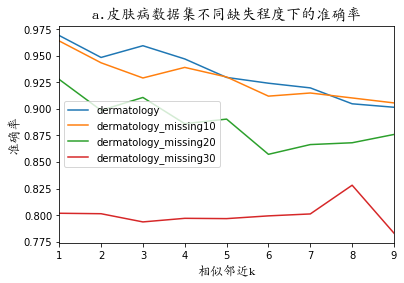

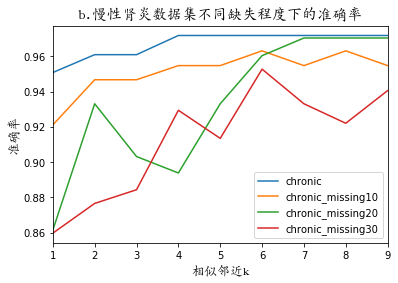

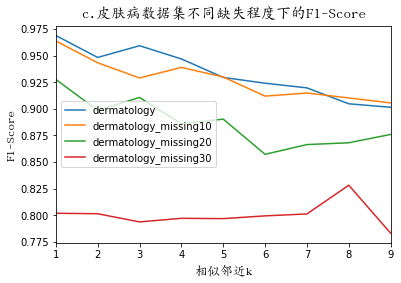

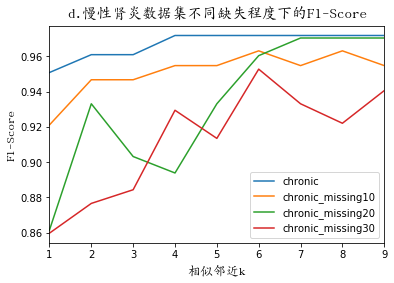

In [96]:
from matplotlib import font_manager
zhfont=font_manager.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')

atts=dataframe.columns.values
chs=[x for x in atts if 'chronic' in x]
#plot_chs=map(lambda x:x.replace(''))
des=[x for x in atts if 'dermatology' in x]

plt.figure()
precisions_df[des].plot()
plt.xlabel(u'相似邻近k',size=13,fontproperties=zhfont)
plt.ylabel(u'准确率',size=13,fontproperties=zhfont)
plt.title(u'a.皮肤病数据集不同缺失程度下的准确率',size=15,fontproperties=zhfont)
plt.show()

precisions_df[chs].plot()
plt.xlabel(u'相似邻近k',size=13,fontproperties=zhfont)
plt.ylabel(u'准确率',size=13,fontproperties=zhfont)
plt.title(u'b.慢性肾炎数据集不同缺失程度下的准确率',size=15,fontproperties=zhfont)
plt.show()

precisions_df[des].plot()
plt.xlabel(u'相似邻近k',size=13,fontproperties=zhfont)
plt.ylabel(u'F1-Score',size=13,fontproperties=zhfont)
plt.title(u'c.皮肤病数据集不同缺失程度下的F1-Score',size=15,fontproperties=zhfont)
plt.show()

precisions_df[chs].plot()
plt.xlabel(u'相似邻近k',size=13,fontproperties=zhfont)
plt.ylabel(u'F1-Score',size=13,fontproperties=zhfont)
plt.title(u'd.慢性肾炎数据集不同缺失程度下的F1-Score',size=15,fontproperties=zhfont)
plt.show()

In [43]:
s='avg / total       0.91      0.87      0.87        92'
print filter(None, s.split(' '))


['avg', '/', 'total', '0.91', '0.87', '0.87', '92']


In [66]:
s='ucf_1_discrete_chronic_missing10Numric'
print s.split('_',2)

['ucf', '1', 'discrete_chronic_missing10Numric']


In [65]:
predictions = {}
predictions["id"] = {'a':"001", 'b':"002"}
predictions["value"] = {'a':"hello boy",'b':"hello world"}
dataFrame = pd.DataFrame.from_dict(predictions)
print(dataFrame)

    id        value
a  001    hello boy
b  002  hello world


In [28]:

def create_rbm_cf_data(path,fname):
    data=pd.read_csv(path+'/'+fname,delimiter=',')
    X=data.iloc[:,:data.shape[1]-1]
    Y=data.iloc[:,data.shape[1]-1]
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state = 41)
    print 'train classes:'
    print pd.value_counts(y_train.values.flatten())
    print 'test classes:'
    print pd.value_counts(y_test.values.flatten())
    X_train=X_train.fillna(-1)
    X_test=X_test.fillna(-1)
    y_test_fill=y_test.where(y_test<0)
    y_test_fill=y_test_fill.fillna(-1)
    test=X_test.join(y_test_fill)
    train=X_train.join(y_train)
    mat=train.append(test)
    n_test=y_test.shape[0]
    outfname=fname.replace('discrete_','')
    outfname=outfname.replace('Numric.csv','')
    labels=mat.iloc[:,mat.shape[1]-1].copy()
    labels[labels<-0.5]=y_test
    print labels
    print labels.values
    #np.save('/home/min/bigdata/data/ex1/data/discrete_data/rbm_datasets/'+outfname,mat.values)
    #np.save('/home/min/bigdata/data/ex1/data/discrete_data/rbm_datasets/testn_'+str(n_test)+'_'+outfname,labels.values)
    print fname
    print 'Job done...'
create_rbm_cf_data('/home/min/bigdata/data/ex1/data/discrete_data/chronic','discrete_chronicNumric.csv')

train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
118    0.0
310    1.0
221    0.0
343    1.0
9      0.0
27     0.0
237    0.0
272    1.0
252    1.0
134    0.0
133    0.0
99     0.0
303    1.0
265    1.0
242    0.0
267    1.0
210    0.0
332    1.0
232    0.0
244    0.0
197    0.0
36     0.0
199    0.0
143    0.0
177    0.0
146    0.0
304    1.0
301    1.0
325    1.0
294    1.0
      ... 
367    1.0
86     0.0
20     0.0
110    0.0
191    0.0
51     0.0
82     0.0
26     0.0
3      0.0
349    1.0
254    1.0
327    1.0
219    0.0
152    0.0
258    1.0
56     0.0
0      0.0
223    0.0
58     0.0
399    1.0
389    1.0
296    1.0
175    0.0
225    0.0
185    0.0
142    0.0
307    1.0
72     0.0
200    0.0
155    0.0
Name: class, Length: 401, dtype: float64
[ 0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0. 

In [26]:
chronic_path='/home/min/bigdata/data/ex1/data/discrete_data/chronic'
dermatology_path='/home/min/bigdata/data/ex1/data/discrete_data/dermatology'
chronic_names=['discrete_chronicNumric.csv','discrete_chronic_missing10Numric.csv','discrete_chronic_missing20Numric.csv','discrete_chronic_missing30Numric.csv']
dermatology_names=['discrete_dermatologyNumric.csv','discrete_dermatology_missing10Numric.csv','discrete_dermatology_missing20Numric.csv','discrete_dermatology_missing30Numric.csv']
for fname in chronic_names:
    create_rbm_cf_data(chronic_path,fname)
for fname in dermatology_names:
    create_rbm_cf_data(dermatology_path,fname)

train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
discrete_chronicNumric.csv
Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
discrete_chronic_missing10Numric.csv
Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
discrete_chronic_missing20Numric.csv
Job done...
train classes:
0    193
1    107
dtype: int64
test classes:
0    58
1    43
dtype: int64
discrete_chronic_missing30Numric.csv
Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
discrete_dermatologyNumric.csv
Job done...
train classes:
0.0    86
2.0    50
1.0    47
3.0    39
4.0    38
5.0    14
dtype: int64
test classes:
0.0    26
2.0    22
4.0    14
1.0    14
3.0    10
5.0     6
dtype: int64
discrete_dermatology_missing10Numric.csv
Job done...
train classe

In [33]:
import cPickle,gzip

def create_drbm_data(path,fname):
    data=pd.read_csv(path+'/'+fname,delimiter=',')
    X=data.iloc[:,:data.shape[1]-1]
    Y=data.iloc[:,data.shape[1]-1]
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state = 41)
    X_train, X_verify, y_train, y_verify= train_test_split(X_train,y_train,test_size=0.25, random_state = 41)
    """
    print 'train classes:'
    print pd.value_counts(y_train.values.flatten())
    print 'test classes:'
    print pd.value_counts(y_test.values.flatten())
    print 'verify classes:'
    print pd.value_counts(y_verify.values.flatten())
    """
    X={'train':[X_train],'test':[X_test],'verify':[X_verify]}
    y={'train':[y_train.values.flatten()],'test':[y_test.values.flatten()],'verify':[y_verify.values.flatten()]}
    label_dict={0:'ckd',1:'notckd'}
    n_classes=2
    dataset_name='chronic'
    if 'dermatology' in fname:
        label_dict={0:'psoriasis',1:'seboreic dermatitis',2:'lichen planus', 3:'pityriasis rosea',4:'cronic dermatitis',5:'pityriasis rubra pilaris'}
        n_classes=6
        dataset_name='dermatology'
    dataset={'X':X,'y':y,'label_dict':label_dict,'n_classes':n_classes,'name':dataset_name}
    fname=fname.replace('.csv','.pkl.gz')
    fw=gzip.open('/home/vitamin/bigdata/code/discriminative-restricted-boltzmann-machine/data/'+dataset_name+'/'+fname,'wb')
    cPickle.dump(dataset,fw)
    fw.close()
    print 'data/'+dataset_name+'/'+fname

In [34]:
chronic_path='/home/min/bigdata/data/ex1/data/discrete_data/chronic'
dermatology_path='/home/min/bigdata/data/ex1/data/discrete_data/dermatology'
chronic_names=['discrete_chronicNumric.csv','discrete_chronic_missing10Numric.csv','discrete_chronic_missing20Numric.csv','discrete_chronic_missing30Numric.csv']
dermatology_names=['discrete_dermatologyNumric.csv','discrete_dermatology_missing10Numric.csv','discrete_dermatology_missing20Numric.csv','discrete_dermatology_missing30Numric.csv']
for fname in os.listdir(chronic_path):
    if  fname not in chronic_names:
        create_drbm_data(chronic_path,fname)
for fname in os.listdir(dermatology_path):
    if  fname not in dermatology_names:
        create_drbm_data(dermatology_path,fname)

data/chronic/discrete_mice_pmm_chronic_missing20Numric.pkl.gz
data/chronic/discrete_chronic_missing30NumricMean.pkl.gz
data/chronic/discrete_mice_cart_chronicNumric.pkl.gz
data/chronic/discrete_KNN3_chronicNumric.pkl.gz
data/chronic/discrete_mice_rf_chronic_missing20Numric.pkl.gz
data/chronic/discrete_KNN2_chronic_missing20Numric.pkl.gz
data/chronic/discrete_KNN2_chronic_missing10Numric.pkl.gz
data/chronic/discrete_mice_rf_chronic_missing10Numric.pkl.gz
data/chronic/discrete_KNN5_chronic_missing10Numric.pkl.gz
data/chronic/discrete_chronic_missing10NumricMean.pkl.gz
data/chronic/discrete_KNN1_chronic_missing20Numric.pkl.gz
data/chronic/discrete_KNN5_chronicNumric.pkl.gz
data/chronic/discrete_KNN1_chronicNumric.pkl.gz
data/chronic/discrete_mice_cart_chronic_missing10Numric.pkl.gz
data/chronic/discrete_KNN3_chronic_missing10Numric.pkl.gz
data/chronic/discrete_mice_rf_chronicNumric.pkl.gz
data/chronic/discrete_KNN1_chronic_missing10Numric.pkl.gz
data/chronic/discrete_chronicNumricMean.pkl

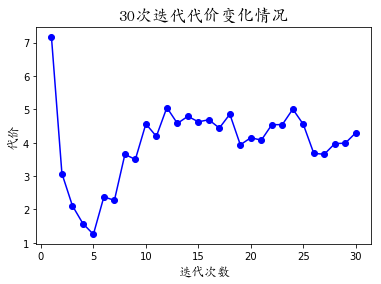

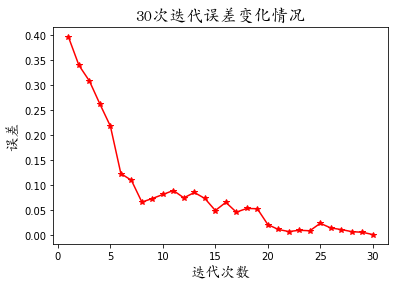

In [40]:
from matplotlib import font_manager
zhfont=font_manager.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')
def plot_rbm_run():
    costs=np.load('/home/vitamin/bigdata/code/Recommendation/costs.npy')
    errors=np.load('/home/vitamin/bigdata/code/Recommendation/errors.npy')
    n=costs.shape[0]
    x=range(1,n+1)
    #print costs
    #print errors
    plt.figure()
    plt.plot(x,costs,'b-o')
    plt.xlabel(u'迭代次数',size=13,fontproperties=zhfont)
    plt.ylabel(u'代价',size=13,fontproperties=zhfont)
    plt.title(u'%d次迭代代价变化情况'%(n),size=17,fontproperties=zhfont)
    plt.show()
    plt.figure()
    plt.plot(x,errors,'r-*')
    plt.xlabel(u'迭代次数',size=15,fontproperties=zhfont)
    plt.ylabel(u'误差',size=15,fontproperties=zhfont)
    plt.title(u'%d次迭代误差变化情况'%(n),size=17,fontproperties=zhfont)
    plt.show()
plot_rbm_run()